In [233]:
import sympy as sp
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from matplotlib import cm
from sympy import cos, sin, exp, Matrix, sqrt
from sympy.simplify.fu import TR10, TR9
import pandas as pd

from IPython.display import display, Math
from IPython.display import display as disp
from utils import symdisp, symplot
import ipywidgets as widgets
from ipywidgets import interact

from commpy.utilities import upsample

from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp import firFilter, pulseShape, lowPassFIR, pnorm, sincInterp
from optic.metrics import signal_power
from optic.plot import eyediagram

In [234]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:,d}'.format

In [235]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [236]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
figsize(8, 3)

# Transmissão Digital da Informação

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#O-modelo-de-canal-AWGN" data-toc-modified-id="O-modelo-de-canal-AWGN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>O modelo de canal AWGN</a></span></li><li><span><a href="#Receptores-e-receptores-ótimos" data-toc-modified-id="Receptores-e-receptores-ótimos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Receptores e receptores ótimos</a></span><ul class="toc-item"><li><span><a href="#Demodulador-por-correlação" data-toc-modified-id="Demodulador-por-correlação-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Demodulador por correlação</a></span></li><li><span><a href="#Demodulador-por-filtro-casado" data-toc-modified-id="Demodulador-por-filtro-casado-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Demodulador por filtro casado</a></span><ul class="toc-item"><li><span><a href="#Filtro-casado" data-toc-modified-id="Filtro-casado-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Filtro casado</a></span></li><li><span><a href="#Maximização-da-$\mathrm{SNR}$" data-toc-modified-id="Maximização-da-$\mathrm{SNR}$-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Maximização da $\mathrm{SNR}$</a></span></li></ul></li></ul></li><li><span><a href="#Detectores-ótimos" data-toc-modified-id="Detectores-ótimos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Detectores ótimos</a></span><ul class="toc-item"><li><span><a href="#Critério-de-decisão-MAP" data-toc-modified-id="Critério-de-decisão-MAP-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Critério de decisão MAP</a></span></li><li><span><a href="#Critério-de-decisão-ML" data-toc-modified-id="Critério-de-decisão-ML-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Critério de decisão ML</a></span></li><li><span><a href="#Métricas-de-decisão" data-toc-modified-id="Métricas-de-decisão-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Métricas de decisão</a></span></li><li><span><a href="#Implementação-de-detectores-MAP-e-ML" data-toc-modified-id="Implementação-de-detectores-MAP-e-ML-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Implementação de detectores MAP e ML</a></span></li><li><span><a href="#Exemplo:-sinal-M-PAM-equiprovável" data-toc-modified-id="Exemplo:-sinal-M-PAM-equiprovável-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Exemplo: sinal M-PAM equiprovável</a></span></li><li><span><a href="#Exemplo:-sinal-M-PAM-não-equiprovável" data-toc-modified-id="Exemplo:-sinal-M-PAM-não-equiprovável-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Exemplo: sinal M-PAM não-equiprovável</a></span></li><li><span><a href="#Exemplo:-sinal-M-QAM-equiprovável" data-toc-modified-id="Exemplo:-sinal-M-QAM-equiprovável-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Exemplo: sinal M-QAM equiprovável</a></span></li><li><span><a href="#Exemplo:-sinal-M-QAM-não-equiprovável" data-toc-modified-id="Exemplo:-sinal-M-QAM-não-equiprovável-3.8"><span class="toc-item-num">3.8&nbsp;&nbsp;</span>Exemplo: sinal M-QAM não-equiprovável</a></span></li></ul></li><li><span><a href="#Referências" data-toc-modified-id="Referências-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Referências</a></span></li></ul></div>

# Receptores ótimos para canais AWGN

<img src="./figuras/Fig1.png" width="900">
 <center>Fig.1: Diagrama de blocos de um sistema de transmissão digital genérico.</center>

##  O modelo de canal AWGN

Considere o modelo de canal em que os sinais transmitidos são afetados apenas por ruído branco gaussiano aditivo (*additive white Gaussian noise* - AWGN). Nesse modelo, o ruído é representado por um processo aleatório gaussiano, ou seja, para cada instante $t$ no tempo, o ruído $n(t)$ adicionado ao sinal é dado por uma variável aleatória gaussiana de média $\mu$ igual a zero e com uma certa variância $\sigma^2$. Desse modo, seja $s(t)$ o sinal enviado pelo transmissor ao canal, o modelo de canal AWGN assume que um ruído $n(t)$ será adicionado ao sinal de informação durante o processo de comunicação, como indicado na figura a seguir

<img src="./figuras/Fig3.png" width="700">
<center>Fig.2: Esquemático de um sistema de transmissão digital via canal AWGN.</center>

em que $r(t)$ representa o sinal ruidoso na entrada do receptor.

Assuma que em cada intervalo de sinalização $T_s$, o transmissor envia um sinal $s_m(t)$ dentre os $M$ possíveis do esquema de modulação utilizado, i.e. $\left\lbrace s_m(t), m = 1,2,\dots, M\right\rbrace$. Considere que no intervalo de $0\leq t \leq T_s$ o transmissor enviou a sinal $s_m(t)$. Uma vez que o canal adiciona ruído ao sinal transmitido, o sinal recebido $r(t)$ no intervalo $0\leq t \leq T_s$ pode ser expresso como

$$\begin{equation}\label{awgnch_eq1} r(t) = s_m(t) + n(t)\end{equation}$$

em que $n(t)$ é uma função amostra de um processo estocástico gaussiano com densidade espectral de potência $S_n(f)=\frac{N_0}{2}$.

## Receptores e receptores ótimos

Baseado na observação de $r(t)$ durante o intervalo de sinalização, o receptor tem a tarefa de inferir qual dos $M$ possíveis sinais foi enviado pelo transmissor. Uma vez que o canal adiciona uma perturbação aleatória ao sinal transmitido, o processo de inferência passa a ter caráter probabilístico. Nesse sentido, sempre existe a possibilidade de que o canal altere a forma do sinal $s_m(t)$ de modo que o sinal recebido possa se assemelhar a um outro sinal do conjunto  $\left\lbrace s_m(t), m = 1,2,\dots, M\right\rbrace$ diferente do que foi transmitido. Logo, se o receptor assume que o sinal transmitido é aquele que tem maior proximidade com o sinal recebido, a presença de ruído pode levar a erros no processo de deteção da informação transmitida. O projeto de receptores ótimos, então, baseia-se no estabelecimento de esquemas de recepção que minimizem a probabilidade da ocorrência de erros no processo de decisão da informação transmitida atrabés do canal.

Como ilustrado na figura abaixo, a tarefa do receptor pode ser subdividida em duas partes:

* **Demodulação**: conversão do sinal recebido $r(t)$ em um vetor de amostras discretas $\mathbf{r} = [r_1,r_2,\dots, r_N]$, em que $N$ é a dimensão dos sinais transmitidos.

* **Detecção**: a partir de $\mathbf{r}$, decidir qual dos $M$ possíveis sinais foram transmitidos.

<img src="./figuras/Fig5.png" width="700">
<center>Fig.3: Estrutura de blocos de um receptor digital.</center>

Para entendermos a tarefa do demodulador, precisamos recorrer ao conceito de espaço de sinais. Considere que os sinais $s_m(t)$ gerados pelo transmissor possam ser expandidos a partir de uma base de $N$ funções ortonormais $f_n(t)$, isto é

$$\begin{equation} s_m(t) = \sum_{k=1}^{N}s_{mk}f_k(t) \end{equation}$$

em que o vetor $\mathbf{s}_m = [s_1, s_2, \dots, s_N]$ corresponde à representação de $s_m(t)$ na base ortonormal $\left\lbrace f_n(t) \right\rbrace_{n=1}^{N}$. Por base ortonormal, entende-se que o produto interno entre duas funções $f_i(t)$ e $f_j(t)$ quaisquer da base obedece a seguinte propriedade

$$\begin{equation} 
\langle f_i(t), f_j(t) \rangle = \int_{-\infty}^{\infty}f_i(t)f_j^*(t) dt = \begin{cases} 1, & \text{ se } i=j\\ 0, & \text{ se } i\neq j \end{cases} \end{equation} $$

em que $^*$ indica o conjugado complexo.

Assim, podemos decompor o sinal $s_m(t)$ em suas componentes vetorias $s_1, s_2, \dots, s_N$ na base $\left\lbrace f_n(t) \right\rbrace_{n=1}^{N}$ realizando o produto interno entre $s_m(t)$ e cada elemento da base no intervalo 
$0\leq t \leq T_s$:

$$\begin{equation} 
\langle s_m(t), f_i(t) \rangle = \int_{0}^{T}s_m(t)f_i^*(t) dt = s_i \end{equation} $$

em que $s_i$ é o componente vetorial de $s_m(t)$ na direção de $f_i(t)$.

### Demodulador por correlação

Na Fig.4 a estrutura de um demodulador por correlação está ilustrada. No receptor, o sinal recebido é correlacionado com cada uma das $N$ funções que compõem a base ortonormal $\left\lbrace f_k(t) \right\rbrace_{k=1}^{N}$, ou seja, cada correlator corresponde à operação

$$\begin{align} 
\langle r(t), f_k(t) \rangle =& \int_{0}^{T}r(t)f_k(t) dt \\
=& \int_{0}^{T}[s_m(t) + n(t)]f_k(t) dt \\
=& \int_{0}^{T}s_m(t)f_k(t)dt + \int_{0}^{T}n(t)f_k(t) dt\\
=& s_{mk} + n_k = r_k
\end{align} $$

com $k=1, 2,\dots, M$.

<img src="./figuras/Fig6.png" width="600">
<center>Fig.4: Demodulador por correlação.</center>

A partir das projeções de $r(t)$ e $n(t)$ nas funções da base ortonormal, podemos escrever

$$\begin{align} r(t) & =\sum_{k=1}^N s_{m k} f_k(t)+\sum_{k=1}^N n_k f_k(t)+n^{\prime}(t) \\ & =\sum_{k=1}^N r_k f_k(t)+n^{\prime}(t)\end{align}$$

em que $n^{\prime}(t)=n(t)-\sum_{k=1}^N n_k f_k(t)$ corresponde aos componentes do ruído que são ortogonais à base ortonormal utilizada na transmissão.

Utilizando as propriedades da média e da autocorrelação do processo estocástico gaussiano estacionário associado ao ruído, temos que:

$$\begin{equation}
E\left[n_k\right]=\int_0^{T_s} E[n(t)] f_k(t) dt=0
\end{equation}$$

e 

$$
\begin{align}
E\left[n_k n_m\right] & = E\left[ \int_0^{T_s} n(t) f_k(t) dt \int_0^{T_s} n(\tau) f_m(\tau) d\tau\right] \\
& = \int_0^{T_s} \int_0^{T_s} E[n(t) n(\tau)] f_k(t) f_m(\tau) d t d \tau \\
& =\frac{N_0}{2}  \int_0^{T_s} \int_0^{T_s} \delta(t-\tau) f_k(t) f_m(\tau) d t d \tau \\
& = \frac{N_0}{2} \int_0^{T_s} f_k(t) \left[\int_0^{T_s} \delta(t-\tau)  f_m(\tau) d \tau \right] d t \\
& =\frac{N_0}{2} \int_0^{T_s} f_k(t) f_m(t) d t \\
& =\frac{N_0}{2} \delta_{m k}
\end{align}
$$

Desse modo, os termos $n_k$ são variáveis aleatórias gaussianas independentes e identicamente distribuídas (i.i.d), com média nula e variância $\sigma_n^2 = E[n_k^2] = \frac{N_0}{2}$.

Assumindo que o sinal $s_m(t)$ seja conhecido, podemos descrever os sinais $r_k$ na saída dos correlatores como variáveis aleatórias gaussianas independentes de média:

$$
\begin{equation}
E\left[r_k\right]=E\left[s_{m k}+n_k\right]=s_{m k} 
\end{equation}
$$
e variância
$$
\begin{align}
\sigma_r^2 &= E\left[r_k^2\right] - E[r_k]^2 \\
&= E\left[s_{mk}^2 + 2s_{mk}n_k + n_k^2\right] - s_{mk}^2\\
&= s_{mk}^2 + E[n_k^2] - s_{mk}^2\\
&= \sigma_n^2=\frac{N_0}{2}.
\end{align}
$$

Portanto, o vetor $\mathbf{r}$ pode ser representado pela seguinte função densidade de probabilidade condicional conjunta

$$ \begin{equation}\label{pdf_conj_1}
p\left(\mathbf{r}|\mathbf{s}_m\right)=\prod_{k=1}^N p\left(r_k|s_{m k}\right), \quad m=1,2, \ldots, M
\end{equation} $$

em que cada componente vetorial possui distribuição condicional

$$\begin{equation}\label{pdf_conj_2}
p\left(r_k|s_{m k}\right)=\frac{1}{\sqrt{\pi N_0}} \exp \left[-\frac{\left(r_k-s_{mk}\right)^2}{N_0}\right], \quad k=1,2, \ldots, N.
\end{equation}$$

Substituindo ($\ref{pdf_conj_2}$) in ($\ref{pdf_conj_1}$), temos:

$$\begin{equation}\label{pdf_conj_3}
p\left(\mathbf{r}|\mathbf{s}_m\right)=\frac{1}{\left(\pi N_0\right)^{N/2}} \exp \left[-\sum_{k=1}^N \frac{\left(r_k-s_{m k}\right)^2}{N_0}\right], \quad m=1,2, \ldots, M
\end{equation}$$

Por fim, faz-se necessário demonstrar que $n^{\prime}(t)$ é irrelevante no processo de decisão sobre qual dos $M$ possíveis sinais foi enviado pelo transmissor. Para tanto, basta mostrar que $n^{\prime}(t)$ e as saídas dos correlatores $r_1, r_2, \dots, r_N$ são independentes. Uma vez que tanto $n^{\prime}(t)$ quanto $r_1, r_2, \dots, r_N$ tem estatística gaussiana, basta mostrar que estes são descorrelacionados. Desse, modo, temos:

$$\begin{aligned} 
E\left[n^{\prime}(t) r_k\right] &= E\left[n^{\prime}(t)\right] s_{m k}+E\left[n^{\prime}(t) n_k\right] \\
&=E\left[n^{\prime}(t) n_k\right] \\ 
&=E\left\{\left[n(t)-\sum_{j=1}^N n_j f_j(t)\right] n_k\right\} \\ 
&=E\left\{\left[n(t)n_k-\sum_{j=1}^N n_j n_k f_j(t)\right] \right\} \\ 
&=E\left\{\left[n(t)\int_0^T n(\tau) f_k(\tau) d\tau -\sum_{j=1}^N n_j n_k f_j(t)\right]  \right\} \\
&=\int_0^T E[n(t) n(\tau)] f_k(\tau) d \tau-\sum_{j=1}^N E\left[n_j n_k\right] f_j(t) \\ 
&=\frac{N_0}{2} f_k(t)-\frac{N_0}{2} f_k(t)=0
\end{aligned}$$

Logo, conclui-se que $n^{\prime}(t)$ e $r_1, r_2, \dots, r_N$ são estatisticamente independentes, sendo as saídas dos correlatores uma *estatística suficiente* para o detector decidir qual sinal foi enviado pelo transmissor. 

### Demodulador por filtro casado

De modo alternativo, o demodulador pode ser construído a partir de um banco de $N$ filtros lineares, como ilustrado na Fig.5. Assuma que a resposta ao impulso $h_k(t)$ de cada um dos $N$ filtros que compõem o banco seja dada por

$$ 
\begin{equation}
h_k(t)=f_k(T_s-t), \quad 0 \leqslant t \leqslant T
\end{equation}
$$

em que $\left\lbrace f_k(t) \right\rbrace_{k=1}^{N}$ são as $N$ funções da base orthonormal e que $h_k(t)=0$ fora do intervalo $0 \leqslant t \leqslant T$.

<img src="./figuras/Fig7.png" width="600">
<center>Fig.5: Demodulador por filtro casado.</center>

Seja $y_k(t)$ a saída do $k$-ésimo filtro, temos que

$$ \begin{align} 
y_k(t) & =\int_0^t r(\tau) h_k(t-\tau) d \tau \\ 
& =\int_0^t r(\tau) f_k(T_s-t+\tau) d \tau, \quad k=1,2, \ldots, N.
\end{align}$$

Se amostrarmos $y_k(t)$ no instante $t=T_s$, temos

$$\begin{equation}
y_k(T_s)=\int_0^t r(\tau) f_k(\tau) d t=r_k, \quad k=1,2, \ldots, N
\end{equation}$$

Desse modo, a saída dos filtros amostrada em $t=T_s$ provê a mesma sequência de valores $r_1, r_2, \dots, r_N$ obtida na saída do banco de correlatores.

#### Filtro casado
Um filtro cuja resposta ao impulso é dada por $h(t) = s(T_s - t)$, em que $s(t)$ está confinada ao intervalo $0\leq t \leq T_s$, é denominado **filtro casado** ao sinal $s(t)$.

$$
\begin{equation}
y(t)=\int_0^t s(\tau) s(T_s-t+\tau) d \tau
\end{equation}
$$

#### Maximização da $\mathrm{SNR}$

A mais importante característica de um filtro casado é que se o sinal $s(t)$ estiver afetado por ruído AWGN, o filtro cuja resposta ao impulso maximiza a $\mathrm{SNR}$ do sinal após a filtragem é o filtro casado de $s(t)$. Para demonstrar essa propriedade, considere que o sinal $r(t) = s(t) + n(t)$ na saída do canal AWGN passa por um filtro de resposta ao impulso $h(t)$. A saída $y(t)$ do filtro será dada por

$$
\begin{align}
y(t) & =\int_0^t r(\tau) h(t-\tau) d \tau \\
& =\int_0^t s(\tau) h(t-\tau) d \tau+\int_0^t n(\tau) h(t-\tau) d \tau.
\end{align}
$$

Amostrando a saída do filtro em $t=T_s$, temos

$$
\begin{align}
y(T_s) & = \int_0^{T_s} s(\tau)h(T_s-\tau)d\tau + \int_0^{T_s}n(\tau)h(T_s-\tau)d\tau\\
& = y_s(T_s)+y_n(T_s).
\end{align}
$$

Desse modo, podemos definir a $\mathrm{SNR}$ do sinal na saída do filtro como
$$
\begin{equation}\label{SNR_o}
\mathrm{SNR} = \frac{y_s^2(T_s)}{E\left[y_n^2(T_s)\right]},
\end{equation}
$$

em que o denominador $E\left[y_n^2(T_s)\right]$ corresponde à variância do ruído na saída do filtro, que podemos reescrever como:

$$
\begin{align}
E\left[y_n^2(T_s)\right] & =\int_0^{T_s} \int_0^{T_s} E[n(\tau) n(t)] h(T_s-\tau) h(T_s-t) d t d \tau \\
& =\frac{N_0}{2} \int_0^{T_s} \int_0^{T_s} \delta(t-\tau) h(T_s-\tau) h(T_s-t) d t d \tau \\
& =\frac{N_0}{2} \int_0^{T_s} h^2(T_s-t) d t.
\end{align}
$$

Logo, temos a seguinte expressão para a $\mathrm{SNR}$ na saída do filtro:
$$
\begin{equation}
\mathrm{SNR} =\frac{\left[\int_0^{T_s} s(\tau) h(T_s-\tau) d \tau\right]^2}{\frac{N_0}{2} \int_0^{T_s} h^2(T_s-t) d t}=\frac{\left[\int_0^{T_s} h(\tau) s(T_s-\tau) d \tau\right]^2}{\frac{N_0}{2} \int_0^{T_s} h^2(T_s-t) d t}.
\end{equation}
$$

Perceba que o termo  $\int_0^{T_s} h^2(T_s-t) d t$ no denominador corresponde à energia de $h(t)$, que pode ser mantida constante. Mantendo-se o denominador constante, a $\mathrm{SNR}$ será máxima se termo $\left[\int_0^{T_s} h(\tau) s(T_s-\tau) d \tau\right]^2$ do numerador for maximizado. Para tanto, considere o resultado da desigualdade de Cauchy-Schwarz que estabelece que para dois sinais $g_1(t)$ e $g_2(t)$ de energia finita 

$$
\begin{equation}
\left[\int_{-\infty}^{\infty} g_1(t) g_2(t) d t\right]^2 \leqslant \int_{-\infty}^{\infty} g_1^2(t) d t \int_{-\infty}^{\infty} g_2^2(t) d t
\end{equation}
$$

com igualdade se, e somente se, $g_1(t) = Cg_2(t)$, sendo $C$ uma constante arbitrária. Logo, a $\mathrm{SNR}$ será máxima quando $h(\tau) = Cs(T_s - \tau)$, ou seja, quando a resposta ao impulso $h(t)$ for casada ao sinal $s(t)$. Neste caso, tem-se que

$$
\begin{align}
\mathrm{SNR} & = \frac{\int_0^{T_s} C^2s^2(T_s-\tau) d \tau \int_0^{T_s}s^2(T_s-\tau) d \tau}{\frac{N_0}{2} \int_0^{T_s} C^2s^2(T_s-t) d t} \\
& =\frac{2}{N_0} \int_0^{T_s} s^2(T_s-\tau) d \tau \\
& =\frac{2}{N_0} \int_0^{T_s} s^2(t) d t \\
& = \frac{2E}{N_0}
\end{align}
$$

em que $E = \int_0^{T_s} s^2(t) d t$ é a energia do sinal $s(t)$. Portanto, a $\mathrm{SNR}$ depende apenas da energia do sinal $s(t)$ e não de qualquer outra característica do mesmo.

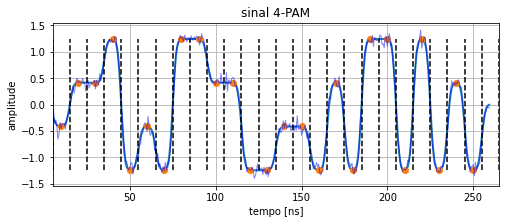

In [238]:
M = 4

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(25*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization
symbTx = np.insert(symbTx,0, 0)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

t = np.arange(0, sigTx.size)*(1/Fa)/1e-9

# instantes centrais dos intervalos de sinalização
symbolsUp = upsample(symbTx, SpS)
symbolsUp[symbolsUp==0] = np.nan

plt.figure(2)
plt.plot(t, sigTx,'-',linewidth=2)
plt.plot(t, symbolsUp.real,'o')
plt.xlabel('tempo [ns]')
plt.ylabel('amplitude')
plt.title('sinal '+str(M)+'-PAM')
plt.grid()

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.0050  # variância
μ   = 0      # média

σ      = sqrt(σ2) 
ruido  = normal(μ, σ, Namostras)

plt.figure(2)
plt.plot(t, sigTx + ruido,'b-',alpha=0.5, linewidth=1)

t = (0.5*Ts + np.arange(0, symbTx.size+1)*Ts)/1e-9
plt.vlines(t, min(symbTx), max(symbTx), linestyles='dashed', color = 'k');
plt.xlim(min(t), max(t));

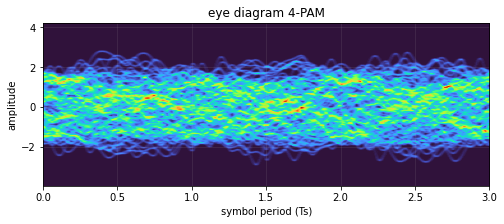

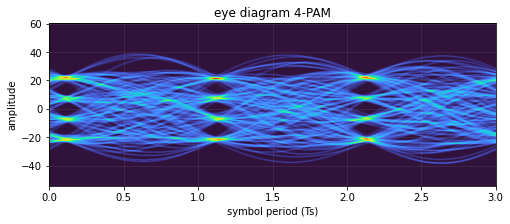

In [239]:
# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(250000*np.log2(M)))

# generate ook modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso 
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.0050 # variância
μ   = 0      # média

σ      = sqrt(σ2*SpS) 
ruido  = normal(μ, σ, Namostras)

# diagrama de olho
Nsamples = sigTx.size
eyediagram(sigTx+ruido, Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')
eyediagram(firFilter(pulse, sigTx+ruido), Nsamples, SpS, plotlabel= str(M)+'-PAM', ptype='fancy')

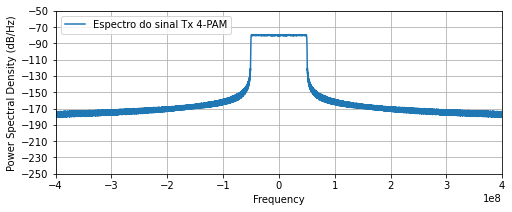

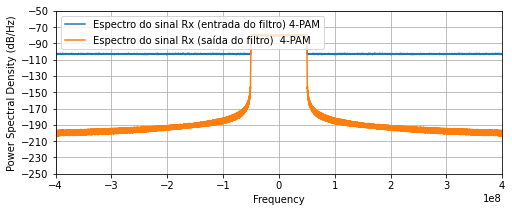

In [240]:
# plot PSD
plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Tx '+ str(M) +'-PAM')
plt.legend(loc='upper left');

plt.figure();
plt.xlim(-4*Rs,4*Rs);
plt.ylim(-250,-50);
plt.psd(sigTx+ruido,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (entrada do filtro) '+ str(M) +'-PAM')
plt.psd(pnorm(firFilter(pulse, sigTx+ruido)),Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal Rx (saída do filtro)  '+ str(M) +'-PAM')
plt.legend(loc='upper left');

## Detectores ótimos

Após a etapa de demodulação, tanto para a demodulação por correlação como para a demodulação por filtro casado, o receptor dispõe de um vetor de amostras $\mathbf{r} = [r_1, r_2, \dots, r_N]$, com distribuição condicional dada por

$$\begin{equation}\label{pdf_conj_4}
p\left(\mathbf{r}|\mathbf{s}_m\right)=\frac{1}{\left(\pi N_0\right)^{N/2}} \exp \left[-\sum_{k=1}^N \frac{\left(r_k-s_{m k}\right)^2}{N_0}\right], \quad m=1,2, \ldots, M,
\end{equation}$$

em que $s_{m k}$ são as componentes ortogonais dos símbolos da constelação e $N_0/2$ a variância do ruído gaussiano adicionado pelo canal. O vetor $\mathbf{r}$ contém toda a informação relevante sobre o sinal recebido. 

Na sequência, com base em $\mathbf{r}$, o receptor deve decidir que símbolo foi transmitido. Esta função é realizada pelo detector. Para cada intervalo de sinalização, baseado na observação de $\mathbf{r}$, o detector deve decidir que símbolo $\mathbf{s}_m$ foi transmitido. O detector ótimo é aquele que maximiza a probabilidade de acerto do símbolo transmitido, ou equivalentemente, minimiza a probabilidade de erro. Para tanto, considera-se uma regra de decisão baseada no cálculo das probabilidades *a posteriori*

$$\begin{equation}\label{posterior_1}
P\left(\text{símbolo }\mathbf{s}_m \text{ foi transmitido}|\mathbf{r}\right), \quad m=1,2, \ldots, M,
\end{equation}$$

abreviadas para $P\left(\mathbf{s}_m|\mathbf{r}\right)$. A regra de decisão a ser implementada consiste em selecionar o símbolo que corresponde ao máximo do conjunto de probabilidades $\left\lbrace P\left(\mathbf{s}_m|\mathbf{r}\right) \right\rbrace$. Será demonstrado que esta regra é ótima, ou seja, é aquela que maximiza a probabilidade de acerto no processo de decisão.

### Critério de decisão MAP
Inicialmente, antes de observar $\mathbf{r}$, o receptor conhece apenas as probabilidades $P(\mathbf{s}_m)$ do transmissor ter enviado cada símbolo $\mathbf{s}_m$. Estas probabilidades representam um conhecimento prévio do receptor acerca dos sinais transmitidos, sendo denominadas probabilidades *a priori*. Uma vez observada a saída do canal $\mathbf{r}$, o receptor pode melhorar a sua estimativa sobre o símbolo transmitido calculando as probabilidades *a posteriori* $P\left(\mathbf{s}_m|\mathbf{r}\right)$ para cada símbolo da constelação e, então, decidir por aquele de maior probabilidade. Este critério de decisão é conhecido como critério de máxima probabilidade *a posteriori* (*maximum a posteriori probability* - MAP.

Utilizando a regra de Bayes, podemos escrever

$$
\begin{align}
P\left(\mathbf{s}_m|\mathbf{r}\right)&=\frac{p\left(\mathbf{r}|\mathbf{s}_m\right) P\left(\mathbf{s}_m\right)}{p(\mathbf{r})}\nonumber\\
&= \frac{p\left(\mathbf{r}|\mathbf{s}_m\right) P\left(\mathbf{s}_m\right)}{\sum_{m=1}^M p\left(\mathbf{r}|\mathbf{s}_m\right) P\left(\mathbf{s}_m\right)}\label{posterior_2}
\end{align}
$$

em que $p\left(\mathbf{r}|\mathbf{s}_m\right)$ é a função densidade de probabilidade condicional de $\mathbf{r}$ dado que $\mathbf{s}_m$ foi transmitido, $P\left(\mathbf{s}_m\right)$ é a probabilidade *a priori* de $\mathbf{s}_m$ ter sido transmitido.

Perceba que no cálculo de $P\left(\mathbf{s}_m|\mathbf{r}\right),\; m=1,2, \ldots, M$, o somatório no denominador da equação ($\ref{posterior_2}$) é independente de $m$, representando apenas um fator de normalização. Logo, seja $\hat{\mathbf{s}}_m$ o símbolo decidido pelo detector, o critério MAP de decisão pode ser expresso como

$$
\begin{align}
\hat{\mathbf{s}}_m &= \arg\max_{\mathbf{s}_m}P\left(\mathbf{s}_m|\mathbf{r}\right)\nonumber\\
&= \arg\max_{\mathbf{s}_m}p\left(\mathbf{r}|\mathbf{s}_m\right)P\left(\mathbf{s}_m\right)\label{MAP_crit}
\end{align}
$$

### Critério de decisão ML

Para o caso em que os símbolos enviados pelo transmissor são equiprováveis, $P\left(\mathbf{s}_m\right) = \frac{1}{M},\; m=1,2, \ldots, M$,  e o critério de decisão MAP definido em ($\ref{MAP_crit}$) pode ser simplificado para

$$
\begin{align}
\hat{\mathbf{s}}_m &= \arg\max_{\mathbf{s}_m}P\left(\mathbf{s}_m|\mathbf{r}\right)\nonumber\\
&= \arg\max_{\mathbf{s}_m}p\left(\mathbf{r}|\mathbf{s}_m\right)\label{ML_crit}
\end{align}
$$

Desse modo, o critério de decisão ótima requer apenas da avaliação da função $p\left(\mathbf{r}|\mathbf{s}_m\right)$. Uma vez que esta densidade de probabilidade condicional (ou qualquer função monotônica da mesma) é conhecida como *função de verossimilhança*, o novo critério denomina-se *critério de máxima verossimilhança*.

### Métricas de decisão

Para o canal AWGN, a função de verossimilhança é dada pela equação ($\ref{pdf_conj_4}$). Por conveniência na simplificação dos cálculos a serem realizados no receptor, utiliza-se a função logaritmo natural de $p\left(\mathbf{r}|\mathbf{s}_m\right)$, que é uma função monotônica, de modo que

$$
\begin{equation}\label{loglikeli}
\ln p\left(\mathbf{r}|\mathbf{s}_m\right)=\frac{-N}{2} \ln \left(\pi N_0\right)-\frac{1}{N_0} \sum_{k=1}^N\left(r_k-s_{m k}\right)^2.
\end{equation}
$$

Maximizar $\ln p\left(\mathbf{r}|\mathbf{s}_m\right)$ equivale a minimizar o somatório do lado direito de ($\ref{loglikeli}$). Por outro lado, este somatório corresponde ao quadrado da distância euclidiana entre $\mathbf{r}$ e $\mathbf{s}_m$. Logo, podemos definir a seguinte métrica $D\left(\mathbf{r}, \mathbf{s}_m\right)$ de distância euclidiana

$$
\begin{equation}\label{metric_dist}
D\left(\mathbf{r}, \mathbf{s}_m\right)=\sum_{k=1}^N\left(r_k-s_{m k}\right)^2 = \| \mathbf{r} - \mathbf{s}_m \|^2.
\end{equation}
$$

Portanto, para a aplicação do critério ML é suficiente que o receptor decida pelo símbolo $\mathbf{s}_m$ que está mais próximo ao sinal recebido $\mathbf{r}$.

Um segundo critério pode ser derivado a partir da expansão de ($\ref{metric_dist}$) em
$$
\begin{align}
D\left(\mathbf{r}, \mathbf{s}_m\right) & =\sum_{n=1}^N r_n^2-2 \sum_{n=1}^N r_n s_{m n}+\sum_{n=1}^N s_{m n}^2 \\
&=\|\mathbf{r}\|^2-2 \mathbf{r} \cdot \mathbf{s}_m+\left\|\mathbf{s}_m\right\|^2, \quad m=1,2, \ldots, M.
\end{align}
$$

Notando que $\|\mathbf{r}\|^2$ é um termo comum a todas $D\left(\mathbf{r}, \mathbf{s}_m\right)$, este pode ser suprimido e a métrica pode ser reescrita como

$$
\begin{equation}\label{metric_dist2}
D^{\prime}\left(\mathbf{r}, \mathbf{s}_m\right)=-2 \mathbf{r} \cdot \mathbf{s}_m+\left\|\mathbf{s}_m\right\|^2.
\end{equation}
$$

Minimizar ($\ref{metric_dist2}$) equivale a maximizar 

$$
\begin{equation}\label{metric_corr}
C \left(\mathbf{r}, \mathbf{s}_m\right) = 2 \mathbf{r} \cdot \mathbf{s}_m-\left\|\mathbf{s}_m\right\|^2.
\end{equation}
$$

A métrica $C \left(\mathbf{r}, \mathbf{s}_m\right)$ é denominada *métrica de correlação*. Nesta métrica, o receptor decide pelo símbolo $\mathbf{s}_m$ que apresenta maior métrica de correlação com o $\mathbf{r}$.

Tanto $D\left(\mathbf{r}, \mathbf{s}_m\right)$ quanto $C\left(\mathbf{r}, \mathbf{s}_m\right)$ são métricas que podem ser utilizadas no caso de todos os símbolos $\mathbf{s}_m$ serem equiprováveis. Entretanto, caso essa condição não seja satisfeita, o critério MAP deve ser aplicado diretamente, o que significa maximizar a seguinte métrica de probabilidade *a posteriori*

$$
\begin{equation}\label{metric_prob}
\operatorname{PM}\left(\mathbf{r}, \mathbf{s}_m\right)= p\left(\mathbf{r}|\mathbf{s}_m\right) P\left(\mathbf{s}_m\right).
\end{equation}
$$

$$
\begin{align}\label{metric_prob_2}
\ln\left[p\left(\mathbf{r}|\mathbf{s}_m\right)P\left(\mathbf{s}_m\right)\right]&=\frac{-N}{2} \ln \left(\pi N_0\right)-\frac{1}{N_0} \sum_{k=1}^N\left(r_k-s_{m k}\right)^2 + \ln P\left(\mathbf{s}_m\right).\nonumber\\
&\propto \sigma_n^2\ln \left(P\left(\mathbf{s}_m\right)\right) - \sum_{k=1}^N\left(r_k-s_{m k}\right)^2 \nonumber\\
\end{align}
$$

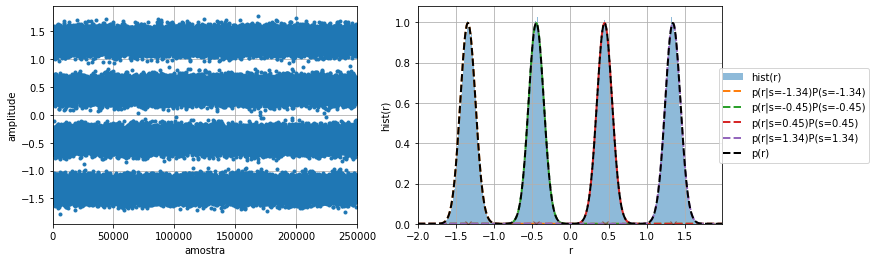

In [241]:
# ruído gaussiano branco
σ2  = 0.01  # variância
μ   = 0      # média

σ     = sqrt(σ2*SpS) 
ruido = normal(μ, σ, sigTx.size)  

constSymb = np.unique(symbTx)

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[2::SpS]

# plota valores de r e histograma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
ax1.plot(r,'.',linewidth = 0.8);
ax1.grid()
ax1.set_xlabel('amostra')
ax1.set_ylabel('amplitude')
ax1.set_xlim(0,r.size);

ax2.hist(r, density=True, bins=300, label = 'hist(r)',alpha=0.5);

x = np.arange(-2, 2, 0.01)
π = np.pi
pdf = 0
for sm in constSymb:
    pdf_c = 1/np.sqrt(2*π*σ2)*np.exp(-(x-sm)**2/(2*σ2))*(1/M) 
    pdf += pdf_c
    ax2.plot(x, pdf_c, '--', label = f'p(r|s={sm:.2f})P(s={sm:.2f})', linewidth=2);
    
ax2.plot(x, pdf, 'k--', label = 'p(r)', linewidth=2);    
ax2.grid()
ax2.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
ax2.set_xlabel('r')
ax2.set_ylabel('hist(r)');
ax2.plot(np.unique(symbTx),np.zeros(M),'x');
ax2.set_xlim(min(x), max(x));

### Implementação de detectores MAP e ML

In [490]:
from numba import njit

@njit
def MLdetector(r, constSymb):   
       
    decided = np.zeros(r.size, dtype=np.complex64) 
    indDec = np.zeros(r.size, dtype=np.int64) 
    π = np.pi  
    
    for ii, ri in enumerate(r): # for each received symbol        
        distMetric = np.zeros(constSymb.size)        
        # calculate distance metric   
        
        # calculate |r-sm|**2, for m= 1,2,...,M
        distMetric = np.abs(ri - constSymb)**2
        
        # find the constellation symbol with the largest P(sm|r)       
        indDec[ii] = np.argmin(distMetric)
        
        # make the decision in favor of the symbol with the smallest metric
        decided[ii] = constSymb[indDec[ii]]
    
    return decided, indDec

@njit
def MAPdetector(r, σ2, constSymb, px=None):        
    
    if px == None:
        px = 1/M*np.ones(M)      
           
    decided = np.zeros(r.size, dtype=np.complex64) 
    indDec = np.zeros(r.size, dtype=np.int64) 
    π = np.pi  
    
    for ii, ri in enumerate(r): # for each received symbol        
        log_probMetric = np.zeros(constSymb.size)        
        # calculate MAP probability metric        
        # calculate log(P(sm|r)) = log(p(r|sm)*P(sm)) for m= 1,2,...,M
        log_probMetric = - np.abs(ri - constSymb)**2/σ2 + np.log(px)
                
        # find the constellation symbol with the largest P(sm|r)       
        indDec[ii] = np.argmax(log_probMetric)
        
        # make the decision in favor of the symbol with the largest metric
        decided[ii] = constSymb[indDec[ii]]
    
    return decided, indDec

In [515]:

def findLimiars(constSymb, σ2=1, px=None):
    
    σ2_x = σ2/2
    σ2_y = σ2/2
    
    M = constSymb.size
    
    if px is None:
        px = 1/M*np.ones(M)     
        
    xmin = np.min(constSymb.real)
    ymin = np.min(constSymb.imag)
    xmax = np.max(constSymb.real)
    ymax = np.max(constSymb.imag)
        
    x = np.linspace(xmin, xmax, 2000)
    y = np.linspace(ymin, ymax, 2000)

    constSymb = np.round(constSymb,2)

    x_const = np.sort(np.unique(constSymb.real))
    y_const = np.sort(np.unique(constSymb.imag))

    lx = np.zeros(x_const.size-1)
    ly = np.zeros(x_const.size-1)

    for ii in range(x_const.size):

        if ii == 0:
            pass
        else:            
            pivot1 = x_const[ii-1] + 1j*y_const[0]
            pivot2 = x_const[ii] + 1j*y_const[0]
            
            x = np.linspace(pivot1.real, pivot2.real, 1000)
            
            p1 = px[constSymb == pivot1]
            p2 = px[constSymb == pivot2]
            
            metric1 = - np.abs(x - x_const[ii-1])**2 / (2*σ2_x) + np.log(p1)
            metric2 = - np.abs(x - x_const[ii]  )**2 / (2*σ2_x) + np.log(p2)
                                    
            lx[ii-1] = np.round(x[np.argmin(np.abs(metric1 - metric2))],2)

    for ii in range(y_const.size):

        if ii == 0:
            pass
        else:            
            pivot1 = x_const[0] + 1j*y_const[ii-1]
            pivot2 = x_const[0] + 1j*y_const[ii]
            
            y = np.linspace(pivot1.imag, pivot2.imag, 1000)
            
            p1 = px[constSymb == pivot1]
            p2 = px[constSymb == pivot2]

            metric1 = - np.abs(y - y_const[ii-1])**2 / (2*σ2_y)  + np.log(p1)
            metric2 = - np.abs(y - y_const[ii])**2 / (2*σ2_y) + np.log(p2)

            ly[ii-1] = np.round(y[np.argmin(np.abs(metric1 - metric2))],2)

    return lx, ly

### Exemplo: sinal M-PAM equiprovável

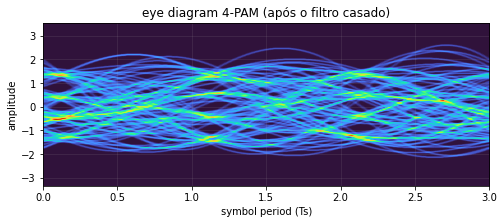

In [565]:
# select PAM order
M = 4

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# get constellation    
constSymb = GrayMapping(M, 'pam')  # constellation
constSymb = pnorm(constSymb) 

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(500000*np.log2(M)))

# generate modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.015 # variância
μ   = 0      # média

σ      = sqrt(σ2*SpS) 
ruido  = normal(μ, σ, Namostras)

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[2::SpS]

# diagrama de olho
Nsamples = 200000*SpS
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-PAM (após o filtro casado)', ptype='fancy')

In [566]:
dec, pos = MAPdetector(r, σ2, constSymb) # detector MAP
#dec, pos = MLdetector(r, constSymb) # detector ML

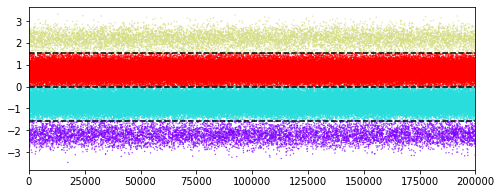

In [575]:
# plota símbolos recebidos e decisões
n_colors = M
colors = cm.rainbow(np.linspace(0, 1, n_colors))
index = np.arange(0,dec.size)
plt.scatter(index, r,c=[colors[ind] for ind in pos], marker='.', s = 0.5);
plt.xlim(0, dec.size);

lx, _ = findLimiars(constSymb, σ2=σ2)
#plt.hlines(constSymb, 0, dec.size, colors='black', linewidth=1);
plt.hlines(lx, 0, dec.size, colors='black', linestyles='dashed');

In [369]:
from optic.metrics import fastBERcalc, theoryBER

ind = np.arange(100,dec.size-100)

SER = 1 - np.sum( np.isclose(dec, symbTx, rtol=1e-2) )/dec.size # calcula SER

SNRb = 10*np.log10(signal_power(sigTx)/(2*σ2)/np.log2(M))

BER_th = theoryBER(M, SNRb,'pam')

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')
print(f'SER(teoria) = {BER_th*np.log2(M):.2e}')

SNRb = 12.22 dB
SER = 2.26e-04
SER(teoria) = 1.96e-04


### Exemplo: sinal M-PAM não-equiprovável

In [370]:
def maxwellBolt(λ, const):
    
    p = np.zeros(const.size)
    
    for ind, x in enumerate(const):
        p[ind] = np.exp(-λ*np.abs(x)**2)
        
    p = p/np.sum(p)
    
    return p

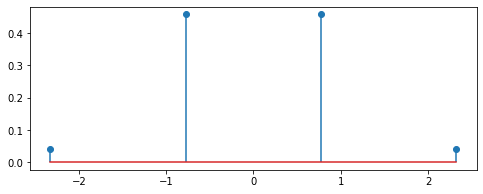

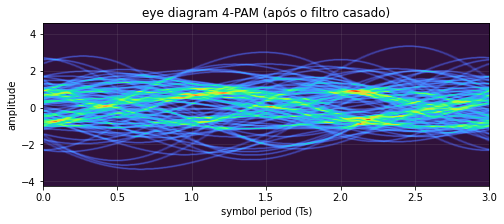

In [570]:
# select PAM order
M = 4

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# gera constelação    
constSymb = GrayMapping(M, 'pam')  # constellation

# define probabilidades de símbolo
constSymb = pnorm(constSymb)

PS = 1.5
probSymb = maxwellBolt(PS, constSymb) 
Es = np.sum(( np.abs(constSymb) ** 2 ) * probSymb)
constSymb = constSymb/np.sqrt(Es)

plt.stem(constSymb, probSymb)

# gera sequência de símbolos modulados
symbTx = np.random.choice(constSymb, 200000, p=probSymb)
symbTx = pnorm(symbTx) # power normalization
    
# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso 
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = sigTx.real
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.1 # variância
μ   = 0   # média

σ      = sqrt(σ2*SpS) 
ruido  = normal(μ, σ, Namostras)

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[2::SpS]

# diagrama de olho
Nsamples = 200000*SpS
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-PAM (após o filtro casado)', ptype='fancy')

In [571]:
#dec, pos = MAPdetector(r, σ2, constSymb, px=probSymb) # detector MAP
dec, pos = MLdetector(r, constSymb) # detector ML

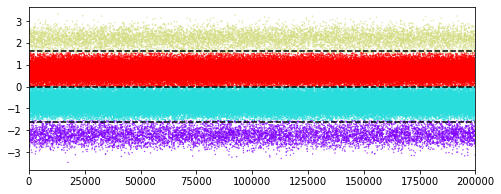

In [573]:
# plota símbolos recebidos e decisões
n_colors = M
colors = cm.rainbow(np.linspace(0, 1, n_colors))
index = np.arange(0,dec.size)
plt.scatter(index, r,c=[colors[ind] for ind in pos], marker='.', s = 0.5);
plt.xlim(0, dec.size);

lx, _ = findLimiars(constSymb, σ2=σ2, px=probSymb)
#plt.hlines(constSymb, 0, dec.size, colors='black', linewidth=1);
plt.hlines(lx, 0, dec.size, colors='black', linestyles='dashed');

In [574]:
ind = np.arange(1000,dec.size-1000)

SER = 1 - np.sum( np.isclose(dec, symbTx, atol=1e-2) )/dec.size # calcula SER

SNRb = 10*np.log10(signal_power(sigTx)/(2*σ2)/np.log2(M))

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')

SNRb = 3.98 dB
SER = 1.12e-02


### Exemplo: sinal M-QAM equiprovável

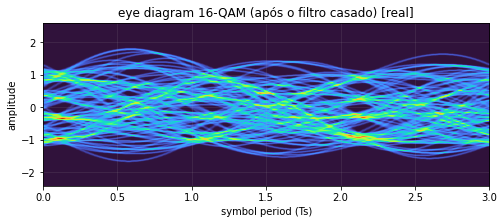

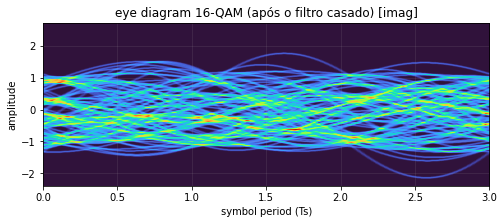

In [559]:
# select QAM order
M = 16

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# get constellation    
constSymb = GrayMapping(M, 'qam')  # constellation
constSymb = pnorm(constSymb) 

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size = int(500000*np.log2(M)))

# generate modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'qam')    
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.025 # variância
μ   = 0      # média

σ      = sqrt(σ2*SpS) 
ruido  = 1/np.sqrt(2)*(normal(μ, σ, Namostras) + 1j*normal(μ, σ, Namostras))

# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[2::SpS]

# diagrama de olho
Nsamples = 200000*SpS
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-QAM (após o filtro casado)', ptype='fancy')

In [560]:
dec, pos = MAPdetector(r, σ2, constSymb) # detector MAP
#dec, pos = MLdetector(r, constSymb) # detector ML

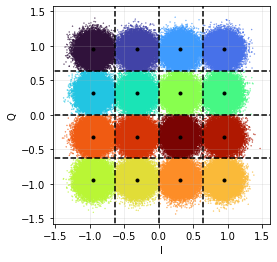

In [562]:
# plota símbolos recebidos e decisões
n_colors = M
colors = cm.turbo(np.linspace(0, 1, n_colors))
index = np.arange(0,dec.size)

plt.figure(figsize=(4,4))
plt.scatter(r.real, r.imag,c=[colors[ind] for ind in pos], marker='.', s = 0.5);
plt.axis('square');
plt.grid(alpha=0.25)
plt.xlabel('I')
plt.ylabel('Q');
plt.plot(constSymb.real, constSymb.imag,'ko', markersize=3);

lx, ly = findLimiars(constSymb, σ2=σ2)

plt.hlines(ly, -3, 3, colors='black', linestyles='dashed');
plt.vlines(lx, -3, 3, colors='black', linestyles='dashed');

In [563]:
ind = np.arange(100,dec.size-100)

SER = 1 - np.sum( np.isclose(dec, symbTx, rtol=1e-2) )/dec.size # calcula SER

SNRb = 10*np.log10(signal_power(sigTx)/σ2/np.log2(M))

BER_th = theoryBER(M, SNRb,'qam')

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')
print(f'SER(teoria) = {BER_th*np.log2(M):.2e}')

SNRb = 10.00 dB
SER = 7.13e-03
SER(teoria) = 7.02e-03


### Exemplo: sinal M-QAM não-equiprovável

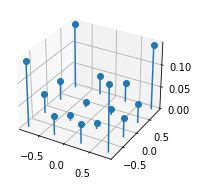

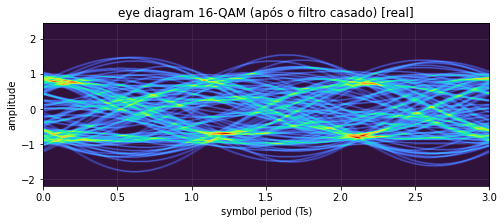

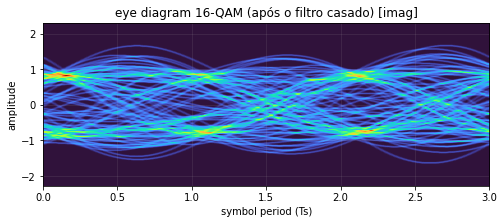

In [598]:
# select PAM order
M = 16

# parâmetros da simulação
SpS = 16            # Amostras por símbolo
Rs  = 100e6         # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

# gera constelação    
constSymb = GrayMapping(M, 'qam')  # constellation

# define probabilidades de símbolo
constSymb = pnorm(constSymb)

PS = -1.5
probSymb = maxwellBolt(PS, constSymb) 
Es = np.sum(( np.abs(constSymb) ** 2 ) * probSymb)
constSymb = constSymb/np.sqrt(Es)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.stem(constSymb.real,constSymb.imag, probSymb, basefmt=" ")

# gera sequência de símbolos modulados
symbTx = np.random.choice(constSymb, 200000, p=probSymb)
symbTx = pnorm(symbTx) # power normalization
    
# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso 
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx = firFilter(pulse, symbolsUp)
sigTx = pnorm(sigTx)

# ruído gaussiano branco
Namostras = sigTx.size
σ2  = 0.025 # variância
μ   = 0   # média

σ      = sqrt(σ2*SpS) 
ruido  = 1/np.sqrt(2)*(normal(μ, σ, Namostras) + 1j*normal(μ, σ, Namostras))


# filtro casado
sigRx = firFilter(pulse, sigTx+ruido)
sigRx = pnorm(sigRx)

# downsampling
r = sigRx[2::SpS]

# diagrama de olho
Nsamples = 200000*SpS
eyediagram(sigRx, Nsamples, SpS, plotlabel= str(M)+'-QAM (após o filtro casado)', ptype='fancy')

In [602]:
#r = r/np.mean(r/symbTx).real
dec, pos = MAPdetector(r, σ2, constSymb, px=probSymb) # detector MAP
#dec, pos = MLdetector(r, constSymb) # detector ML

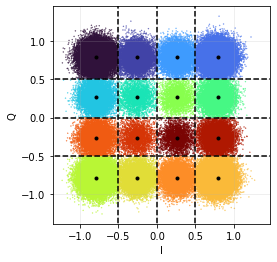

In [603]:
# plota símbolos recebidos e decisões
n_colors = M
colors = cm.turbo(np.linspace(0, 1, n_colors))
index = np.arange(0,dec.size)

plt.figure(figsize=(4,4))
plt.scatter(r.real, r.imag,c=[colors[ind] for ind in pos], marker='.', s = 0.5);
plt.axis('square');
plt.grid(alpha=0.25)
plt.xlabel('I')
plt.ylabel('Q');
plt.plot(constSymb.real, constSymb.imag,'ko',markersize=3);

lx, ly = findLimiars(constSymb, σ2=σ2, px=probSymb)
plt.hlines(ly, -3, 3, colors='black', linestyles='dashed');
plt.vlines(lx, -3, 3, colors='black', linestyles='dashed');

In [604]:
ind = np.arange(100,dec.size-100)

SER = 1 - np.sum( np.isclose(dec[ind], symbTx[ind], rtol=1e-2) )/dec.size # calcula SER

SNRb = 10*np.log10(signal_power(sigTx)/σ2/np.log2(M))

print(f'SNRb = {SNRb:.2f} dB')
print(f'SER = {SER:.2e}')

SNRb = 10.00 dB
SER = 1.99e-02


## Referências

[1] J. G. Proakis, M. Salehi, Communication Systems Engineering, 2nd Edition, Pearson, 2002.